In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

画像データの取得

In [4]:
thermal_img_files = dataloader.get_img_files(dir_path="./images/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images/modules",gray=True)

In [5]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

温度データの取得

In [6]:
data = ThermalData(thermal_img_files)

温度分布の確認（個別）

In [7]:
for k in list(data.temperature.keys())[:10]:
    print(k)    
    v = data.temperature[k]
    filepath = "./hist/hist_" + k
    display.display_distributions(v, filepath, show=False)

63.jpg
189.jpg
77.jpg
162.jpg
176.jpg
88.jpg
200.jpg
201.jpg
188.jpg
76.jpg


温度分布の確認（全体）

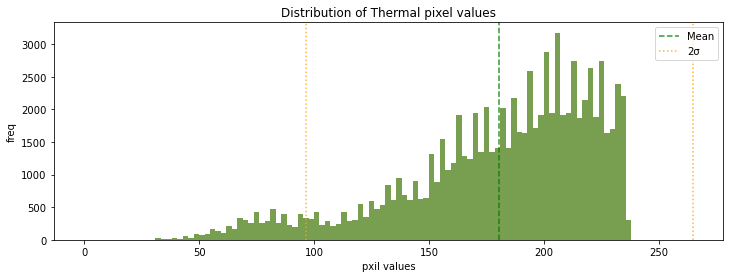

In [8]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

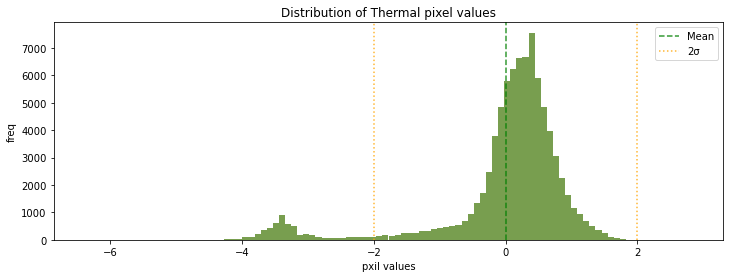

In [9]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

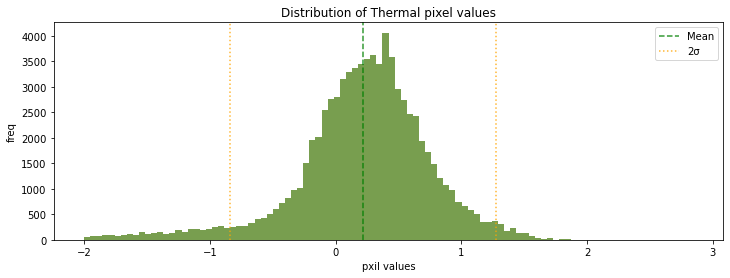

In [10]:
mask = (data.scaled_all_temperature > -2).all(axis=1)
display.display_distributions(data.scaled_all_temperature[mask], 
                              filepath = "hist_masked_scaled_all_themal_data.jpg")

個別画像の分析

In [11]:
input_file = "72.jpg"
#input_file = "12.jpg"
#input_file = "126.jpg"
#input_file = "130.jpg"

クラスタリング

In [12]:
#km = clustering.get_kmeans(data.scaled_temperature[input_file], n_clusters=8) # temperautre
#km = clustering.get_kmeans(data.scaled_temperature_with_index[input_file][:, :-2], n_clusters=8) # index
km = clustering.get_kmeans(data.scaled_temperature_with_index[input_file], n_clusters=8) # all

In [13]:
clusters_temperature = clustering.get_clusters_data(km, data.temperature[input_file])

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [15]:
#display.plot_2d_scatters_for_clusters(clusters_temperature)

In [16]:
#display.plot_3d_scatters_for_clusters(clusters_temperature)

In [17]:
centers_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in clusters_temperature])

In [18]:
from sklearn import preprocessing
mscaler = preprocessing.MinMaxScaler()

In [19]:
img_clustered = centers_temperature[km.labels_]
img_clustered = img_clustered.reshape(thermal_img_files[input_file].shape)

In [20]:
colors = cm.viridis(km.labels_)[:, :3]
img_colored = np.uint8(mscaler.fit_transform(colors) * 255)
img_colored = img_colored.reshape(thermal_img_files[input_file].shape)
img_colored  = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)

In [21]:
mask = data.scaled_temperature[input_file] > -2
mask = mask.reshape(thermal_img_files[input_file].shape)

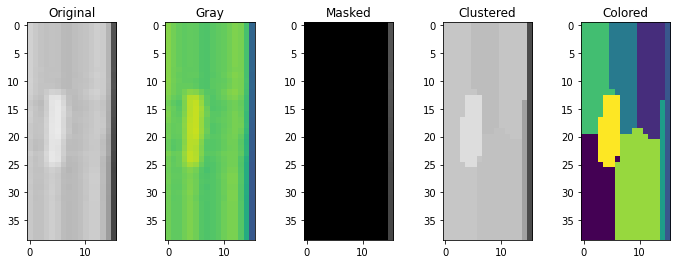

In [22]:
display.display_modules({
    "Original": thermal_img_files[input_file], 
    "Gray": thermal_img_files_gray[input_file],
    "Masked": (thermal_img_files[input_file]*~mask),
    "Clustered": img_clustered,
    "Colored": img_colored,
})

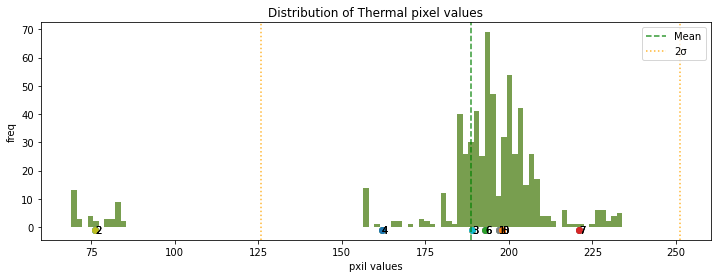

In [23]:
display.display_distributions(data.temperature[input_file], 
                              filepath = "test.jpg", cluster_centers = centers_temperature)

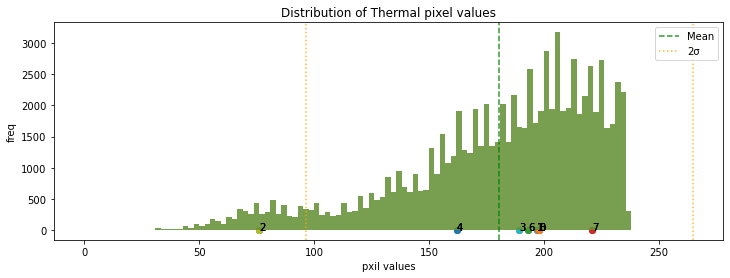

In [24]:
display.display_distributions(data.all_temperature, 
                              filepath = "test.jpg", cluster_centers = centers_temperature)

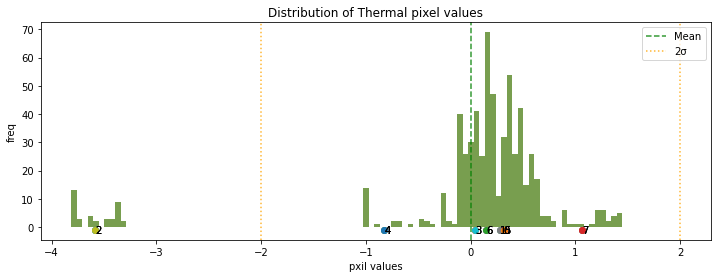

In [25]:
display.display_distributions(data.scaled_temperature[input_file], 
                              filepath = "test.jpg", cluster_centers = km.cluster_centers_[:,:3])

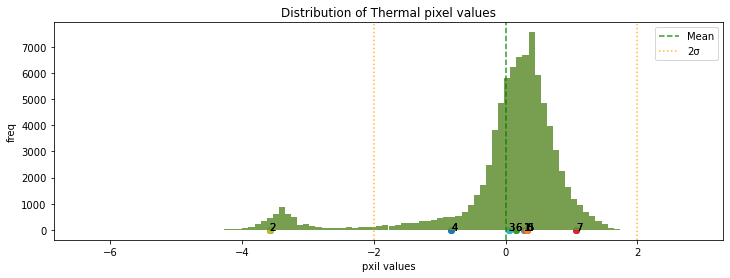

In [26]:
display.display_distributions(data.scaled_all_temperature, 
                              filepath = "test.jpg", cluster_centers = km.cluster_centers_[:,:3])

In [27]:
gmm = anomaly_detection.get_gmm(data.all_temperature)
#gmm = anomaly_detection.get_gmm(data.scaled_all_temperature)
index2class = anomaly_detection.get_index2class(gmm)

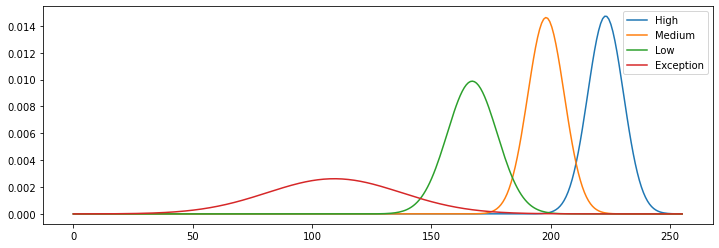

In [28]:
from scipy import stats
fig = plt.figure(figsize=(12,4),facecolor="w")
ax1 = fig.add_subplot(1,1,1)
#x = np.linspace(-6, 2, 300)
x = np.linspace(0, 255, 300)
gd = []
for idx, c in index2class.items():
    gd = stats.norm.pdf(x, gmm.means_[idx, -1], np.sqrt(gmm.covariances_[idx]))
    plt.plot(x, gmm.weights_[idx] * gd, label=c)
plt.legend()
plt.show()

In [29]:
predicted_classes = gmm.predict(centers_temperature)

In [30]:
cluster_types = [ index2class[c] for c in predicted_classes ]

In [31]:
cluster_types

['Medium', 'Medium', 'Exception', 'Medium', 'Low', 'Medium', 'Medium', 'High']

In [32]:
# 異常クラス判定

In [33]:
def detect_module_type(cluster_types):
    hot_counts = cluster_types.count("High")
    if hot_counts == 1:
        module_type = "Single-Hotspot"
    elif hot_counts >= 2:
        module_type = "Multi-Hotspots"
    else:
        module_type = "Normal"
    return module_type

In [34]:
detect_module_type(cluster_types)

'Single-Hotspot'

In [35]:
# 異常タイプの確認テスト

189.jpg Multi-Hotspots
['High', 'Exception', 'High', 'High', 'High', 'Medium', 'High', 'High']


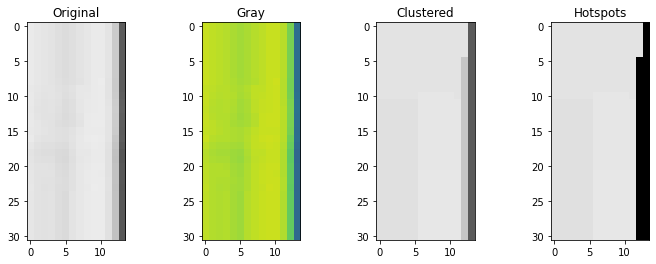

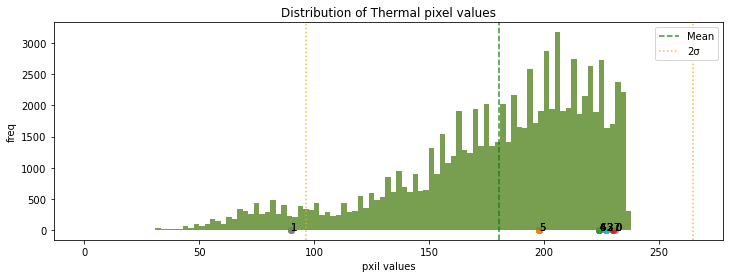

77.jpg Normal
['Exception', 'Low', 'Exception', 'Low', 'Low', 'Low', 'Low', 'Low']


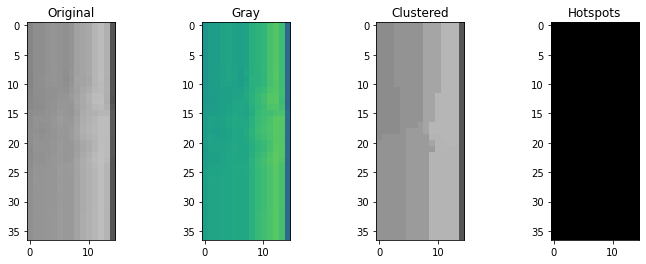

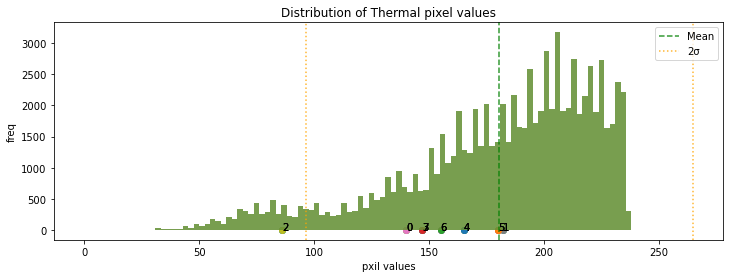

162.jpg Single-Hotspot
['Medium', 'Exception', 'Medium', 'Exception', 'High', 'Low', 'Low', 'Low']


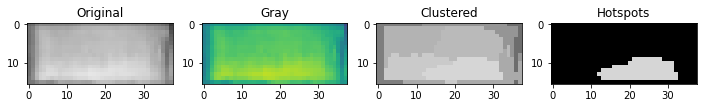

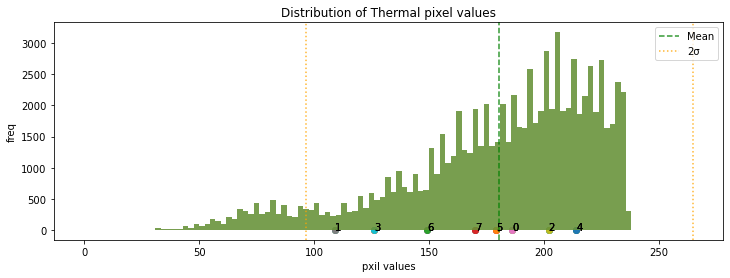

176.jpg Multi-Hotspots
['High', 'Medium', 'High', 'Exception', 'High', 'High', 'Exception', 'Low']


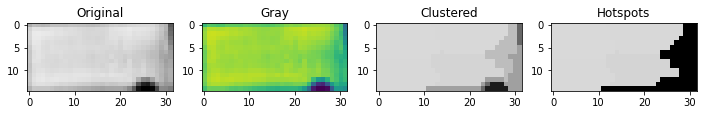

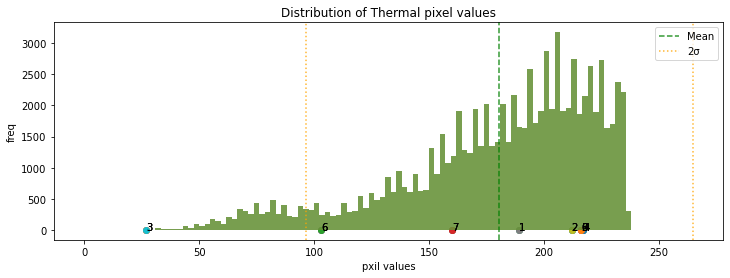

88.jpg Normal
['Low', 'Low', 'Exception', 'Medium', 'Low', 'Low', 'Exception', 'Exception']


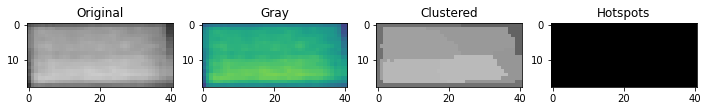

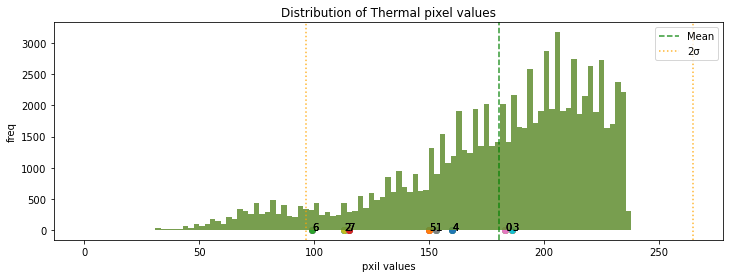

200.jpg Multi-Hotspots
['High', 'Exception', 'High', 'High', 'High', 'High', 'Medium', 'High']


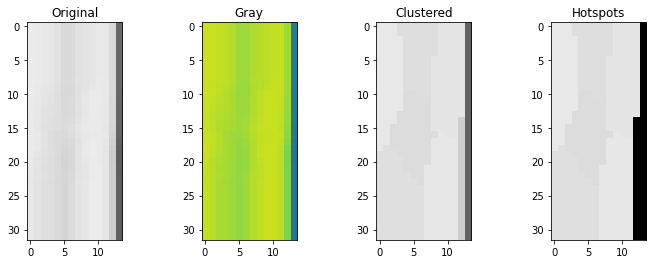

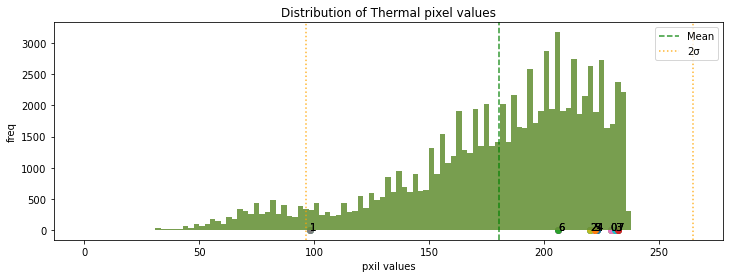

201.jpg Multi-Hotspots
['High', 'High', 'Exception', 'High', 'High', 'High', 'High', 'Medium']


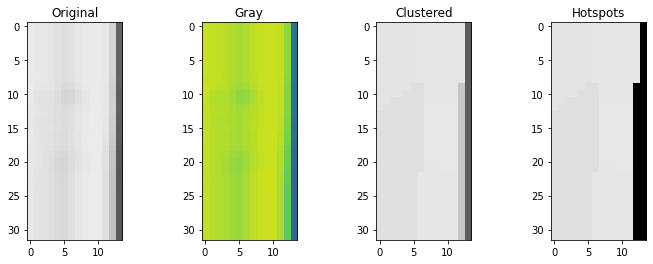

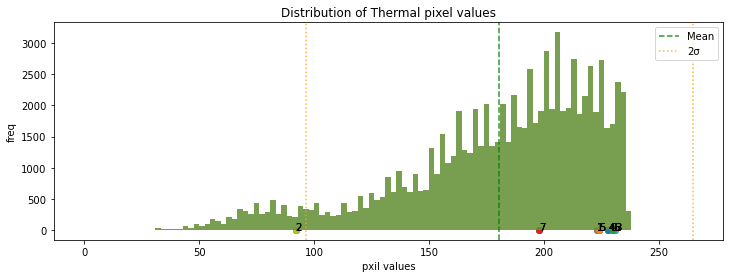

188.jpg Multi-Hotspots
['High', 'High', 'Exception', 'High', 'Low', 'Exception', 'High', 'High']


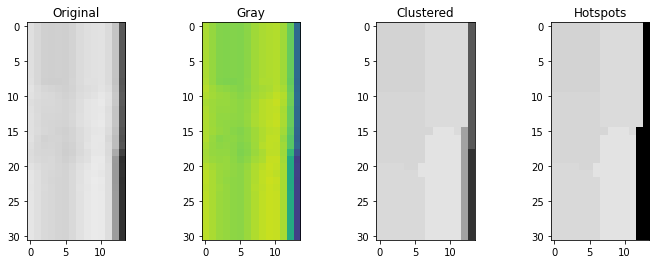

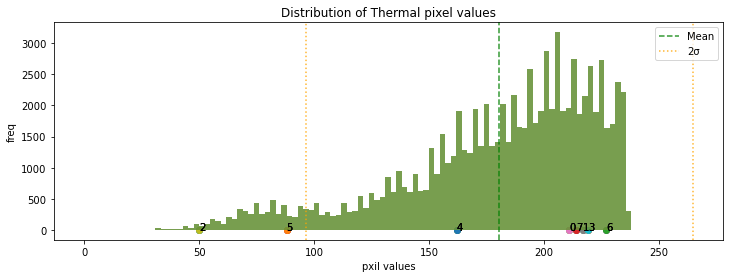

76.jpg Normal
['Low', 'Low', 'Exception', 'Exception', 'Low', 'Low', 'Exception', 'Exception']


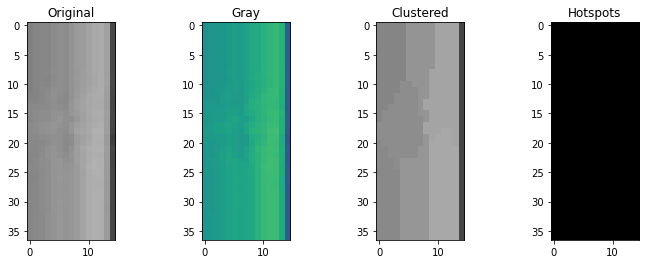

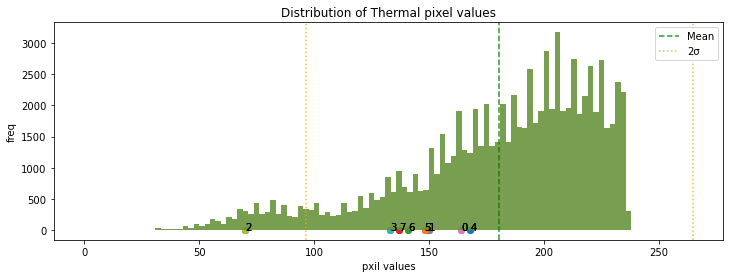

In [36]:
for k in list(data.temperature.keys())[1:10]:
    # -- kmeans ---
    km = clustering.get_kmeans(data.scaled_temperature_with_index[k], n_clusters=8)
    clusters_temperature = clustering.get_clusters_data(km, data.temperature[k])
    centers_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in clusters_temperature])
    # -- gmm -- 
    #predicted_classes = gmm.predict(km.cluster_centers_[:, :3])
    predicted_classes = gmm.predict(centers_temperature)
    cluster_types = [ index2class[c] for c in predicted_classes ]
    # -- anomaly type --
    module_type = detect_module_type(cluster_types)
    print(k, module_type)    
    print(cluster_types)
    # -- display -- 
    img_clustered = centers_temperature[km.labels_] 
    weights = np.array([ index2class[c] =="High" for c in predicted_classes[km.labels_] ])        
    img_hotspots = img_clustered * weights.reshape(-1,1)
    img_clustered = img_clustered.reshape(thermal_img_files[k].shape)
    img_hotspots = img_hotspots.reshape(thermal_img_files[k].shape)
    display.display_modules({
        "Original": thermal_img_files[k], 
        "Gray": thermal_img_files_gray[k],
        "Clustered": img_clustered,
        "Hotspots": img_hotspots,
    })
    display.display_distributions(
        data.all_temperature, 
        filepath = "hist_on_all_"+k,
        cluster_centers = centers_temperature
    )

In [37]:
#ToDo
## 分布に対してGMMをオーバーラップしたい
## クラスタ異常を追加（面積ベース？）
## 異常部分へのマーキング（赤で囲む）